# Sensitivity Analysis

Test here: (local) sensitivity analysis of kinematic parameters with respect to a defined objective function. Aim: test how sensitivity the resulting model is to uncertainties in kinematic parameters to:

1. Evaluate which the most important parameters are, and to
2. Determine which parameters could, in principle, be inverted with suitable information.

## Theory: local sensitivity analysis

Basic considerations:

- parameter vector $\vec{p}$
- residual vector $\vec{r}$
- calculated values at observation points $\vec{z}$
- Jacobian matrix $J_{ij} = \frac{\partial \vec{z}}{\partial \vec{p}}$

Numerical estimation of Jacobian matrix with central difference scheme (see Finsterle):

$$J_{ij} = \frac{\partial z_i}{\partial p_j} \approx \frac{z_i(\vec{p}; p_j + \delta p_j) - z_i(\vec{p};p_j - \delta p_j)}{2 \delta p_j}$$

where $\delta p_j$ is a small perturbation of parameter $j$, often as a fraction of the value.


## Defining the responses $\vec{z}$

A meaningful sensitivity analysis obviously depends on the definition of a suitable response vector $\vec{z}$. Ideally, these responses are related to actual observations. In our case, we first want to determine how sensitive a kinematic structural geological model is with respect to uncertainties in the kinematic parameters. We therefore need calculatable measures that describe variations of the model.

As a first-order assumption, we will use a notation of a stratigraphic distance for discrete subsections of the model, for example in single voxets for the calculated model. We define distance $d$ of a subset $\omega$ as the (discrete) difference between the (discrete) stratigraphic value of an ideal model, $\hat{s}$, to the value of a model realisation $s_i$:

$$d(\omega) = \hat{s} - s_i$$

In the first example, we will consider only one response: the overall sum of stratigraphic distances for a model realisation $r$ of all  subsets (= voxets, in the practical sense), scaled by the number of subsets (for a subsequent comparison of model discretisations):

$$D_r = \frac{1}{n} \sum_{i=1}^n d(\omega_i)$$


Note: mistake before: not considering distances at single nodes but only the sum - this lead to "zero-difference" for simple translation! Now: consider more realistic objective function, squared distance:

$$r = \sqrt{\sum_i (z_{i calc} - z_{i ref})^2}$$


In [7]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [8]:
%matplotlib inline

# Setting up the base model

For a first test: use simple two-fault model from paper

In [16]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
os.chdir(r'/Users/flow/git/pynoddy/docs/notebooks/')
repo_path = os.path.realpath('../..')
import pynoddy.history
import pynoddy.events
import pynoddy.output

In [10]:
reload(pynoddy.history)
reload(pynoddy.events)
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 8,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3', 'layer 4', 'layer 5', 'layer 6', 'layer 7', 'layer 8'],
                  'layer_thickness' : [1500, 500, 500, 500, 500, 500, 500, 500]}
nm.add_event('stratigraphy', strati_options )

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_W',
                 'pos' : (4000, 3500, 5000),
                 'dip_dir' : 90,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (6000, 3500, 5000),
                 'dip_dir' : 270,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
history = "two_faults_sensi.his"
nm.write_history(history)

In [11]:
output_name = "two_faults_sensi_out"
# Compute the model
pynoddy.compute_model(history, output_name) 


''

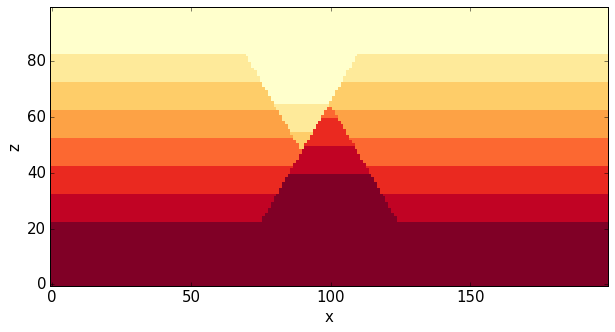

In [12]:
# Plot output
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('y', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False)

## Define parameter uncertainties

We will start with a sensitivity analysis for the parameters of the fault events. 

In [17]:
H1 = pynoddy.history.NoddyHistory(history)
# get the original dip of the fault
dip_ori = H1.events[3].properties['Dip']
# dip_ori1 = H1.events[2].properties['Dip']
# add 10 degrees to dip
add_dip = -20
dip_new = dip_ori + add_dip
# dip_new1 = dip_ori1 + add_dip

# and assign back to properties dictionary:
H1.events[3].properties['Dip'] = dip_new



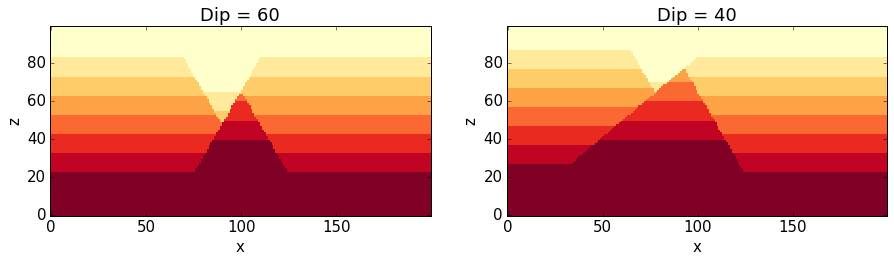

In [18]:
reload(pynoddy.output)
new_history = "sensi_test_dip_changed.his"
new_output = "sensi_test_dip_changed_out"
H1.write_history(new_history)
pynoddy.compute_model(new_history, new_output)
# load output from both models
NO1 = pynoddy.output.NoddyOutput(output_name)
NO2 = pynoddy.output.NoddyOutput(new_output)

# create basic figure layout
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
NO1.plot_section('y', position=0, ax = ax1, colorbar=False, title="Dip = %.0f" % dip_ori)
NO2.plot_section('y', position=0, ax = ax2, colorbar=False, title="Dip = %.0f" % dip_new)

plt.show()



## Calculate total stratigraphic distance


In [21]:
# def determine_strati_diff(NO1, NO2):
#     """calculate total stratigraphic distance between two models"""
#     return np.sum(NO1.block - NO2.block) / float(len(NO1.block))

def determine_strati_diff(NO1, NO2):
    """calculate total stratigraphic distance between two models"""
    return np.sqrt(np.sum((NO1.block - NO2.block)**2)) / float(len(NO1.block))



diff = determine_strati_diff(NO1, NO2)
print(diff)

5.56205897128


## Function to modify parameters

Multiple event parameters can be changed directly with the function `change_event_params`, which takes a dictionarly of events and parameters with according changes relative to the defined parameters. Here a brief example:

In [23]:
# set parameter changes in dictionary

changes_fault_1 = {'Dip' : -20}
changes_fault_2 = {'Dip' : -20}
param_changes = {2 : changes_fault_1,
                 3 : changes_fault_2}

In [24]:
reload(pynoddy.history)
H2 = pynoddy.history.NoddyHistory(history)
H2.change_event_params(param_changes)

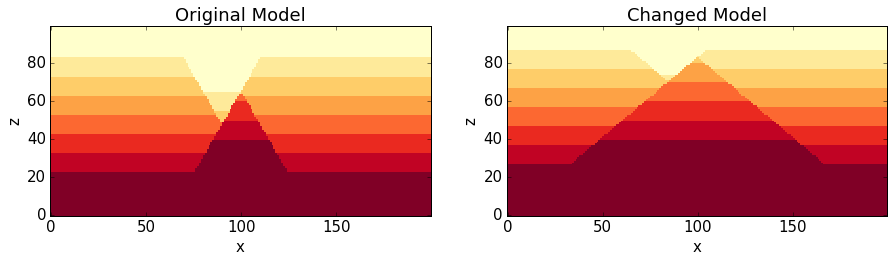

In [25]:
new_history = "param_dict_changes.his"
new_output = "param_dict_changes_out"
H2.write_history(new_history)
pynoddy.compute_model(new_history, new_output)
# load output from both models
NO1 = pynoddy.output.NoddyOutput(output_name)
NO2 = pynoddy.output.NoddyOutput(new_output)

# create basic figure layout
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
NO1.plot_section('y', position=0, ax = ax1, colorbar=False, title="Original Model")
NO2.plot_section('y', position=0, ax = ax2, colorbar=False, title="Changed Model")

plt.show()

## Full sensitivity analysis

Perform now a full sensitivity analysis for all defined parameters and analyse the output matrix. For a better overview, we first create a function to perform the sensitivity analysis:

In [43]:
import copy
new_history = "sensi_tmp.his"
new_output = "sensi_out"
def noddy_sensitivity(history_filename, param_change_vals):
    """Perform noddy sensitivity analysis for a model"""
    param_list = [] # list to store parameters for later analysis
    distances = [] # list to store calcualted distances
    # Step 1:
    # create new parameter list to change model
    for event_id, event_dict in param_change_vals.items(): # iterate over events
        for key, val in event_dict.items(): # iterate over all properties separately
            changes_list = dict()
            changes_list[event_id] = dict()
            param_list.append("event_%d_property_%s" % (event_id, key))
            for i in range(2):
                # calculate positive and negative values
                his = pynoddy.history.NoddyHistory(history_filename)
                if i == 0:
                    changes_list[event_id][key] = val
                    # set changes
                    his.change_event_params(changes_list)
                    # save and calculate model
                    his.write_history(new_history)
                    pynoddy.compute_model(new_history, new_output)
                    # open output and calculate distance
                    NO_tmp = pynoddy.output.NoddyOutput(new_output)
                    dist_pos = determine_strati_diff(NO1, NO_tmp)
                    NO_tmp.plot_section('y', position = 0, colorbar = False, title = "Dist: %.2f" % dist_pos,
                                        savefig = True, 
                                        fig_filename = "event_%d_property_%s_val_%d.png" % (event_id, key,val))
                if i == 1:
                    changes_list[event_id][key] = -val
                    his.change_event_params(changes_list)
                    # save and calculate model
                    his.write_history(new_history)
                    pynoddy.compute_model(new_history, new_output)
                    # open output and calculate distance
                    NO_tmp = pynoddy.output.NoddyOutput(new_output)
                    dist_neg = determine_strati_diff(NO1, NO_tmp)
                    NO_tmp.plot_section('y', position=0, colorbar=False, title="Dist: %.2f" % dist_neg,
                                        savefig=True, 
                                        fig_filename="event_%d_property_%s_val_%d.png" % (event_id, key,val))
            # calculate central difference
            central_diff = (dist_pos + dist_neg) / (2.)
            distances.append(central_diff)
    return param_list, distances

            

As a next step, we define the parameter ranges for the local sensitivity analysis (i.e. the $\delta p_j$ from the theoretical description above): 

In [44]:
changes_fault_1 = {'Dip' : 1.5,
                   'Dip Direction' : 10,
                   'Slip': 100.0,
                   'X': 500.0}
changes_fault_2 = {'Dip' : 1.5,
                   'Dip Direction' : 10,
                   'Slip': 100.0,
                   'X': 500.0}
param_changes = {2 : changes_fault_1,
                 3 : changes_fault_2}

And now, we perform the local sensitivity analysis:

In [ ]:
param_list_1, distances = noddy_sensitivity(history, param_changes)

The function passes back a list of the changed parameters and the calculated distances according to this change. Let's have a look at the results:

In [51]:
for p,d in zip(param_list_1, distances):
    print "%s \t\t %f" % (p, d)

event_2_property_X 		 2.716228
event_2_property_Dip 		 1.410039
event_2_property_Dip Direction 		 2.133553
event_2_property_Slip 		 1.824993
event_3_property_X 		 3.323528
event_3_property_Dip 		 1.644589
event_3_property_Dip Direction 		 2.606573
event_3_property_Slip 		 1.930455


Results of this local sensitivity analysis suggest that the model is most sensitive to the X-position of the fault, when we evaluate distances as simple stratigraphic id differences. Here just a bar plot for better visualisation (feel free to add proper labels):

<Container object of 8 artists>

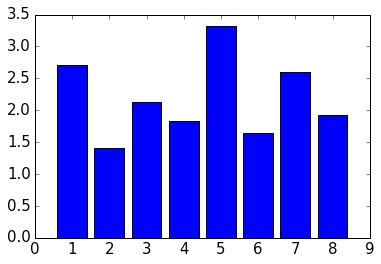

In [47]:
d = np.array([distances])
plt.bar(np.arange(0.6,len(distances),1.), np.array(distances[:]))

The previous experiment showed how `pynoddy` can be used for simple scientific experiments. The sensitivity analysis itself is purely local. A better way would be to use (more) global sensitivity analysis, for example using the Morris or Sobol methods. These methods are implemented in the Python package `SALib`, and an experimental implementation of this method into `pynoddy` exists, as well (see further notebooks on repository, note: no guaranteed working, so far!).